<a href="https://colab.research.google.com/github/harim0207/KampenTeam/blob/Harim/Copy_of_Exports_Canny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
print(ee.__version__)
ee.Authenticate()

0.1.236
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lQtY4AO6SwcLAZ0uwGP-kKFzbmMOvPvDkyhTeJoZO1w&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4gFAxDIoHaBUaXm_0YNQ90auVAadPceqMzR6JgbcFcJpP35ac6i10bk

Successfully saved authorization token.


In [ ]:
ee.Initialize()

geometry = ee.Geometry.Point([-86.92935317664569,40.44445370290157])
# Sentinel: ee.ImageCollection("COPERNICUS/S2_SR")
# NAIP: ee.ImageCollection("USDA/NAIP/DOQQ")
img_set = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(geometry) \
    .filterDate('2014-07-03', '2020-01-01') \
    .sort('CLOUD_COVER')

# Number of images:
print("We have {} images for this point.".format(img_set.size().getInfo()))

# The diff bands:
print(img_set.first().bandNames().getInfo())

# Least cloudiest image:
print(img_set.first().get('CLOUD_COVER').getInfo())

# selecting the least cloudiest image with bands
# Sentinel bands: ['B4', 'B3', 'B2']
# NAIP bands: ['R', 'G', 'B']
image = ee.Image(img_set.first()).select(['R', 'G', 'B'])
print(type(image))
# print(image.get('system:asset_size'))


We have 3 images for this point.
['R', 'G', 'B', 'N']
None
<class 'ee.image.Image'>


In [ ]:
# Export tiff files to Google Drive
task = ee.batch.Export.image.toDrive(image=image,
                                     region=[[-86.933730541758,40.45118134445295], 
                                             [-86.92643493323749,40.45131197160421],
                                             [-86.92463248877948,40.43929321080908],
                                             [-86.93270057349628,40.439227885585325],
                                             [-86.933730541758,40.45118134445295]],
                                     folder='APIpractice',
                                     description='imageToDriveExample',
                                     fileNamePrefix='testing',
                                     scale=0.5)

task.start()
task.status()

# bandNames = img.bandNames();
# print(image)

In [ ]:
# For getting URL to download to computer
path = image.getDownloadURL({
    'scale': 20,
    'crs': 'EPSG:4326',
    'region': '[[-86.933730541758,40.45118134445295],\
                [-86.92643493323749,40.45131197160421],\
                [-86.92463248877948,40.43929321080908],\
                [-86.93270057349628,40.439227885585325],\
                [-86.933730541758,40.45118134445295]]'
})

print(path)

End of download images.
Next section is dealing with downloaded image.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/My Drive/APIpractice")
!ls

Mounted at /content/drive
blur.png	KampenNAIP.tif	    sharpen2.png
greyscale.png	KampenSentinel.tif  testNAIP.tif
KampenNAIP.png	sharpen1.png	    testSentinel.tif


(2685, 1546)


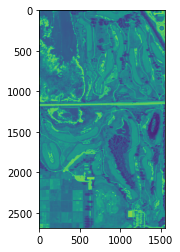

(2684, 1546)


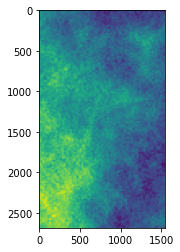

In [ ]:
import glob
!pip install rasterio
import rasterio
from matplotlib import pyplot

for item in glob.glob("Kampen*.tif"):
  file = rasterio.open(item)
  array = file.read(1)
  print(array.shape)
  '''use (array, cmap='Blues') or some other cmap options for bands'''
  pyplot.imshow(array) 
  pyplot.show() 


In [ ]:
from PIL import Image

im = Image.open("KampenNAIP.tif")
im.save("KampenNAIP.png")

In [ ]:
!ls

KampenNAIP.png	KampenSentinel.tif  testSentinel.tif
KampenNAIP.tif	testNAIP.tif


In [ ]:
from PIL import Image, ImageFilter

# Open an already existing image
imageObject = Image.open("KampenNAIP.png")
blur = imageObject.filter(ImageFilter.BLUR)
sharpened1 = imageObject.filter(ImageFilter.SHARPEN)
sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)
blur.save("blur.png")
sharpened1.save("sharpen1.png")
sharpened2.save("sharpen2.png")


In [ ]:
'''resizing image'''
import PIL
from PIL import Image
basewidth = 300
img = Image.open("KampenNAIP.png")
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save("bigger.png")

Start of canny edge detection

In [ ]:
'''In order for convolve to work in Canny_detector() below, the img dimensions 
and kernel dimensions need to be the same therefore check image dimensions'''
from PIL import Image
'''
plates = Image.open('greyscale.png')'''
import matplotlib.image as mpimg
plates = mpimg.imread('greyscale.png')
print(plates.shape)
#(height, width, color)
plates = plates[:,:,0]
print(plates.shape)

(2685, 1546, 4)
(2685, 1546)


In [ ]:
from scipy import ndimage

''' Gaussian kernal is for the amount that the greyscale image is blurred in 
order to reduce noise in the image'''
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

''' Edges correspond to a change of pixels’ intensity. To detect it, the sobel
filter emphasizes this intensity change in both directions: x and y'''
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)
    
''' The ideal final image should have thin lines showing the edges. To do this, 
the algorithm goes through all the points on the gradient intensity matrix and 
finds the pixels with the maximum value in the edge directions.'''
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    #pi_4 = np.pi / 4
    #pi_2 = np.pi / 2
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                #theta = D[i,j] #* 180 / np.pi #angle in degrees
                #theta_mod = theta % np.pi
                q = 255
                r = 255
                #alpha = None
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                

            except IndexError as e:
                pass
    
    return Z

''' After the non_max_suppression() the resulting image has 3 different types of
pixels: strong intensity(sure to contribute to the edges), weak(in between), and
non-relevannt(too weak and are not considered an edge). The high threshold
determines the strong pixels and the low determines the non-relevant'''
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)
'''Hysteresis is a method of edge tracking in which it compares weak pixels to 
surrounding pixels and iff at least one is a strong pixel, it will convert the 
weak pixel to a strong pixel.'''
def hysteresis(img, weak, strong=255):
    
    M, N = img.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    
    return img

In [ ]:
from skimage.feature import canny
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np


def Canny_detector(img):
    img_filtered = convolve(img, gaussian_kernel(3, sigma=1.4))
    grad, theta = sobel_filters(img_filtered)
    img_nms = non_max_suppression(grad, theta)
    img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.07, highThresholdRatio=0.19)
    img_final = hysteresis(img_thresh, weak, strong=strong)
   
    return img_final

In [ ]:
'''canny_imgs = []
for i, img in enumerate(plates):
    print("Processing image %i" % (i+1))
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')'''

canny_img = Canny_detector(plates)

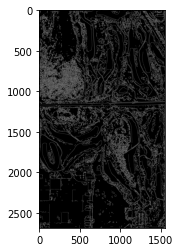

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(canny_img, cmap='gray', vmin=0, vmax=255)
        
plt.show()

In [ ]:
import imageio
imageio.imwrite('Canny.png', canny_img)